In [135]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, wordpunct_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

In [136]:
# Load dataframes and make a cobined dataframe for making models
df_appwatch = pd.read_csv('../data/apple_watch.csv')
df_galaxy = pd.read_csv('../data/galaxy_watch.csv')
df = pd.concat([df_appwatch, df_galaxy], axis=0)
print(f'apple watch dataframe shape ------------- {df_appwatch.shape}')
print(f'galaxy watch dataframe shape ------------ {df_galaxy.shape}')
print(f'final (combined) data frame shape ------- {df.shape}')

apple watch dataframe shape ------------- (1996, 5)
galaxy watch dataframe shape ------------ (1999, 5)
final (combined) data frame shape ------- (3995, 5)


In [137]:
df.head()

,Unnamed: 0,author,description,num_comments,subreddit
0,0,Mnml_Id,Those Apple Watch Ultra Mod kit are looking go...,0,AppleWatch
1,1,BigMasterDingDong,Is there a way to increase the time between a ...,0,AppleWatch
2,2,Cedar_Wood_State,Just want an app that I can use the record my ...,0,AppleWatch
3,3,clarebear-82,[removed]Fitness recovery app that monitors HR...,0,AppleWatch
4,4,tomo128,Move goal 300%,0,AppleWatch


In [138]:
# drop unusefull columns
df.drop(columns =['Unnamed: 0', 'author', 'num_comments'], inplace=True)

In [139]:
df['subreddit'].value_counts()

GalaxyWatch    1999
AppleWatch     1996
Name: subreddit, dtype: int64

In [140]:
# create label column (target column)
df['subreddit'] = df['subreddit'].map({'GalaxyWatch': 1, 'AppleWatch':0})

In [141]:
df.isna().sum()

description    0
subreddit      0
dtype: int64

In [142]:
df.dtypes

description    object
subreddit       int64
dtype: object

In [143]:
df.to_csv('../data/final.csv')

## Function

#### Before starting modeling, I just made a funtion for stemming texts, which might be usefull for my models

In [144]:
# cite: Got help form Katie Sylvia
# a function for stemming
def stem_words(text):
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Stem each word and join them back into a string
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text

## Modeling

In [145]:
# define X (features) and y(target)
X = df['description']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(f'X shape ---------- {X.shape}')
print(f'y shape ---------- {y.shape}')

X shape ---------- (3995,)
y shape ---------- (3995,)


### Baseline accuracy

In [146]:
y_test.value_counts(normalize=True)

1    0.500501
0    0.499499
Name: subreddit, dtype: float64

Baseline accuracy score is 0.50

## Naïve Bayes Algorithm with CountVectorizer

In [147]:
# describe pipeline with multinomial Naïve Bayes algorithm with countvectorizer transformer
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [148]:
# get to know pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [149]:
# set pipeline params by cvec
pipe_params = {
    'cvec__tokenizer': [None, stem_words],
    'cvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [150]:
# Grid search over with pipeline estimator
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=5)

# fit the model to traning data
gs.fit(X_train, y_train)

# get to know wich params were best ones
print(f'The best params  ---------- {gs.best_params_}')

# get to know the best score
print(f'The best score  ----------- {gs.best_score_}')

The best params  ---------- {'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'cvec__tokenizer': None}
The best score  ----------- 0.886848080133556


In [151]:
# train data score
gs.score(X_train, y_train)

0.9516021361815754

In [152]:
# test data score
gs.score(X_test, y_test)

0.8928928928928929

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


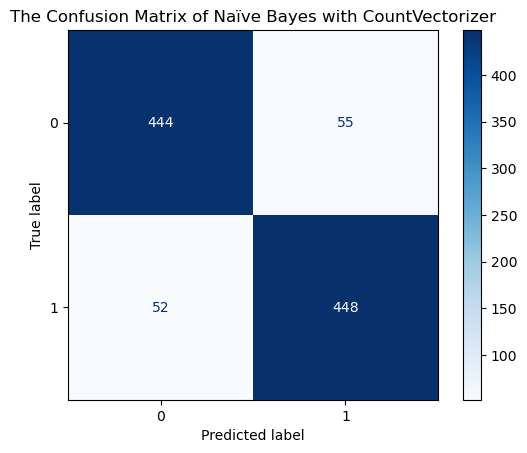

In [153]:
# Get predictions
preds = gs.predict(X_test)

#confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d')

plt.title('The Confusion Matrix of Naïve Bayes with CountVectorizer');

### Evaluation for Model with Multinomial Naïve Bayes Algorithm and CountVectorizer Transformer

In [154]:
print(f'The accuracy score  ---------- {accuracy_score(y_test, preds)}')
print(f'The precision score  --------- {precision_score(y_test, preds)}')
print(f'The sensitivity score  ------- {recall_score(y_test, preds)}')
print(f'The specifity score  --------- {tn/(tn + fp)}')

The accuracy score  ---------- 0.8928928928928929
The precision score  --------- 0.8906560636182903
The sensitivity score  ------- 0.896
The specifity score  --------- 0.8897795591182365


## Naïve Bayes Algorithm with TfidVectorizer

In [155]:
# redifine training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [156]:
# describe pipeline with multinomial Naïve Bayes algorithm with tfidvectorizer transformer
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [157]:
# get to know pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [158]:
# set pipeline params by tvec
pipe_tvec_params = {
    'tvec__tokenizer': [None, stem_words],
    'tvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [159]:
# Grid search over with pipeline estimator
gs_tvec = GridSearchCV(pipe_tvec, param_grid=pipe_tvec_params, cv=5, n_jobs=5)

# fit the model to traning data
gs_tvec.fit(X_train, y_train)

# get to know wich params were best ones
gs_tvec.best_params_

# get to know wich params were best ones
print(f'The best params  ---------- {gs_tvec.best_params_}')

# get to know the best score
print(f'The best score  ----------- {gs_tvec.best_score_}')

The best params  ---------- {'tvec__max_df': 0.9, 'tvec__max_features': 10000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__tokenizer': None}
The best score  ----------- 0.8808441847523649


In [160]:
# train data score
gs_tvec.score(X_train, y_train)

0.9686248331108144

In [161]:
# test data score
gs_tvec.score(X_test, y_test)

0.8938938938938938

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


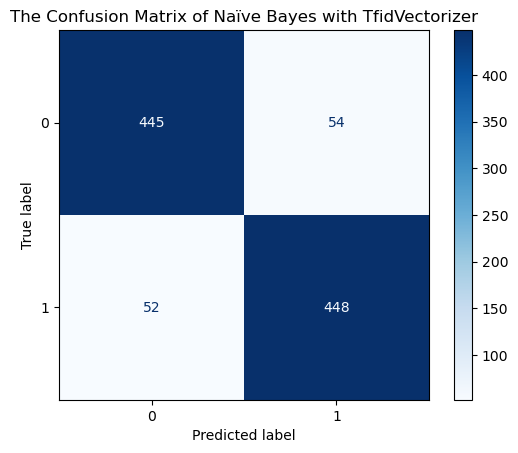

In [162]:
# Get predictions
preds = gs_tvec.predict(X_test)

#confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# confusion matrix
plot_confusion_matrix(gs_tvec, X_test, y_test,
                      cmap='Blues', values_format='d')
plt.title('The Confusion Matrix of Naïve Bayes with TfidVectorizer');

### Evaluation for Model with Multinomial Naïve Bayes Algorithm and TfidVectorizer Transformer

In [163]:
print(f'The accuracy score with  ----- {accuracy_score(y_test, preds)}')
print(f'The precision score   -------- {precision_score(y_test, preds)}')
print(f'The sensitivity score  ------- {recall_score(y_test, preds)}')
print(f'The specifity score  --------- {tn/(tn + fp)}')

The accuracy score with  ----- 0.8938938938938938
The precision score   -------- 0.8924302788844621
The sensitivity score  ------- 0.896
The specifity score  --------- 0.8917835671342685
